# Corporación Favorita Time Series - Data Wrangling

***
<br>




<img src="../../reports/img/Corporación_Favorita_Logo.png" width=400 height=300 />

<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This is the first section after the <b>problem identification</b> step. In the next few lines of code I did some data wrangling. This consists on taking raw data and preparing it for processing and analysis. In this particular notebook what we are doing is reducing our dataset to something locally manageable and dealing with null values and data types.<p>
</div>

<br>

### Table of Contents

- [Importing Libraries](#importing)
- [Data Collection](#collection)
- [Data Definition](#definition)
- [Data Cleaning](#cleaning)
- [Merging the datasets](#merge)
- [Saving the dataset](#saving)

<a id='importing'></a>

## Importing libraries

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tqdm
import os.path
from datetime import datetime

#Settings
sns.set()
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

<a id='collection'></a>

## Data Collection

***

This dataset comes from a Kaggle competition called [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data) the dataset is very large +5GB it is not added in this repository.

There are 7 relevant datasets:
 - `train`
 - `test`
 - `items`
 - `stores`
 - `transactions`
 - `holidays`
 - `oil`

In [2]:
# We load the datasets
if os.path.isfile('train_clean.csv') == True:
    df = pd.read_csv('train_clean.csv', parse_dates=['date'], date_parser=dateparse, dtype={'onpromotion': object})
    df = df.iloc[:,1:]
    
else:    
    train = pd.read_csv(r'/Users/diego/Documents/Favorita/train.csv', parse_dates=['date'], date_parser=dateparse,
                    dtype={'id': int, 'store_nbr': int, 'item_nbr': int, 'unit_sales': float})


In [3]:
test = pd.read_csv(r'/Users/diego/Documents/Favorita/test.csv', parse_dates=['date'], date_parser=dateparse)
items = pd.read_csv(r'/Users/diego/Documents/Favorita/items.csv')
stores = pd.read_csv(r'/Users/diego/Documents/Favorita/stores.csv')
transactions = pd.read_csv(r'/Users/diego/Documents/Favorita/transactions.csv', parse_dates=['date'], date_parser=dateparse)
holidays = pd.read_csv(r'/Users/diego/Documents/Favorita/holidays_events.csv', parse_dates=['date'], date_parser=dateparse)
oil = pd.read_csv(r'/Users/diego/Documents/Favorita/oil.csv', parse_dates=['date'], date_parser=dateparse)

<a id='definition'></a>

## Data Definition & Cleaning
***

In [4]:
# Check the shape
print(holidays.shape)
print(oil.shape)
print(items.shape)
print(stores.shape)
print(test.shape)
print(transactions.shape)

try:
    print(train.shape)
except NameError:
    print(df.shape)

(350, 6)
(1218, 2)
(4100, 4)
(54, 5)
(3370464, 5)
(83488, 3)
(2562153, 6)


In [5]:
def nulls(dataframe):
    '''Checks what percent of null values are in each column'''
    for i in dataframe.columns:
        print(i,str(sum(dataframe[i].isnull())/len(dataframe)*100)+'%')

<br>

**stores.csv**

- Store metadata, including `city`, `state`, `type`, and `cluster`.
- `cluster` is a grouping of similar stores.


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
nulls(stores)

store_nbr 0.0%
city 0.0%
state 0.0%
type 0.0%
cluster 0.0%


In [9]:
stores[stores['city']=='Quito']

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
16,17,Quito,Pichincha,C,12


<br>

**train.csv**

Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
- The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
- Negative values of unit_sales represent returns of that particular item.
- The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
- Approximately 16% of the onpromotion values in this file are NaN.
    
NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

In [ ]:
train.info()

In [52]:
# The train dataset is very large, let's reduce it to make it manageable for a personal computer. Let's look at the first rows
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [82]:
nulls(train)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 17.257499459748214%


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.6+ GB


<br>

<div class='alert alert-danger'>
    For this analysis we will reduce the original dataset and keep data from 1 store
</div>

In [11]:
select_store_number = 1

In [12]:
number_store_selected = stores[stores['store_nbr'] == select_store_number]['store_nbr'][0]
city_store_selected = stores[stores['store_nbr'] == select_store_number]['city'][0]

In [13]:
# We will take the store numbers 1 to 3 as a way to simplify the dataset
if os.path.isfile('train_clean.csv') == True:
    pass
else:
    df = train[train['store_nbr'].isin([number_store_selected])] 
    df.to_csv('train_clean.csv')

In [14]:
df.shape

(2562153, 6)

In [15]:
nulls(df)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 18.923655222775533%


<br>

**test.csv**

- Test data, with the `date`, `store_nbr`, `item_nbr` combinations that are to be predicted, along with the `onpromotion` information.

- NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products..

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB


In [17]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [18]:
nulls(test)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
onpromotion 0.0%


In [19]:
# We will take the store numbers 1 to 3 as a way to simplify the dataset
test = test[test['store_nbr'].isin([number_store_selected])]

<br>

**items.csv**

- Item metadata, including `family`, `class`, and `perishable`.
- NOTE: Items marked as `perishable` have a score weight of 1.25; otherwise, the weight is 1.0.


In [20]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [21]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [22]:
#Not all items are present in every store, here we select the items of interest to us
items_in_selected_store = df['item_nbr'].unique().tolist()
items = items[items['item_nbr'].isin(items_in_selected_store)]

<br>

**transactions.csv**

- The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [24]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [25]:
transactions = transactions[transactions['store_nbr'].isin([number_store_selected])]

In [26]:
nulls(transactions)

date 0.0%
store_nbr 0.0%
transactions 0.0%


<br>

**oil.csv**

- Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [27]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [28]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [29]:
oil.columns = ['date','price']

In [30]:
nulls(oil)

date 0.0%
price 3.5303776683087027%


In [31]:
print('There are {} null values'.format(len(oil[oil['price'].isnull() == True])))

There are 43 null values


<br>

**holidays_events.csv**

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [32]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [33]:
nulls(holidays)

date 0.0%
type 0.0%
locale 0.0%
locale_name 0.0%
description 0.0%
transferred 0.0%


In [34]:
holidays = holidays[(holidays['locale_name'] == city_store_selected) |
                     (holidays['locale'] == 'National') &
                     (holidays['date'] >= '2013-01-01')]

<br>

To understand better our data we will check how the time data is structured, are there gaps between the data we have?

In [35]:
def check_gaps(dataframe):
    '''plots a dataframe's date column and checks if there are gaps'''
    times_gaps = pd.DataFrame(dataframe.date.unique()) - pd.DataFrame(dataframe.date.unique()).shift(1)
    times_gaps.columns = ['gaps']
    plt.figure(figsize=(20,6))
    plt.scatter(x=dataframe.date.unique(), y=times_gaps.gaps.dt.days)
    plt.show()

In [36]:
#let's now check if there are any gaps in our timeseries data. We put all the datasets into a list of dataframes
dataframes = {'Train':df, 'Test':test, 'Items':items, 'Stores':stores, 'Holidays': holidays, 'Oil':oil, 'Transactions': transactions}

TRAIN
Columns:  ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
Unique values: 1678
 First observation:  2013-01-02 00:00:00 
 Last observation:  2017-08-15 00:00:00
Gaps between observed data


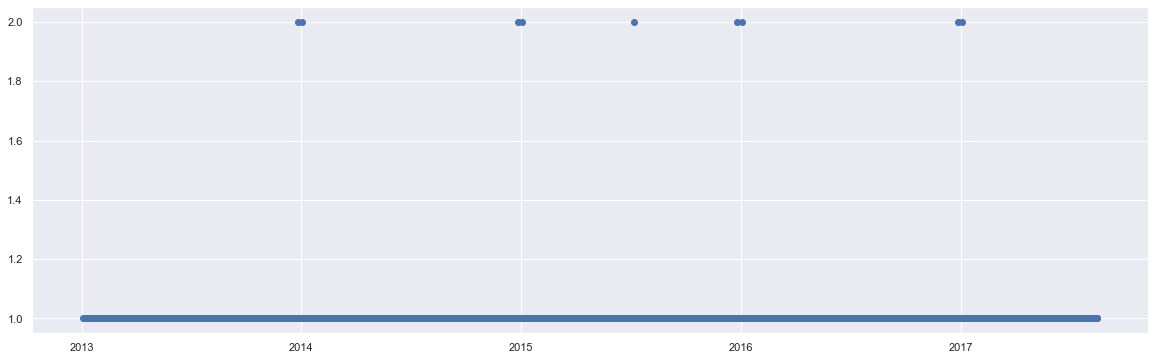

 
TEST
Columns:  ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion']
Unique values: 16
 First observation:  2017-08-16 00:00:00 
 Last observation:  2017-08-31 00:00:00
Gaps between observed data


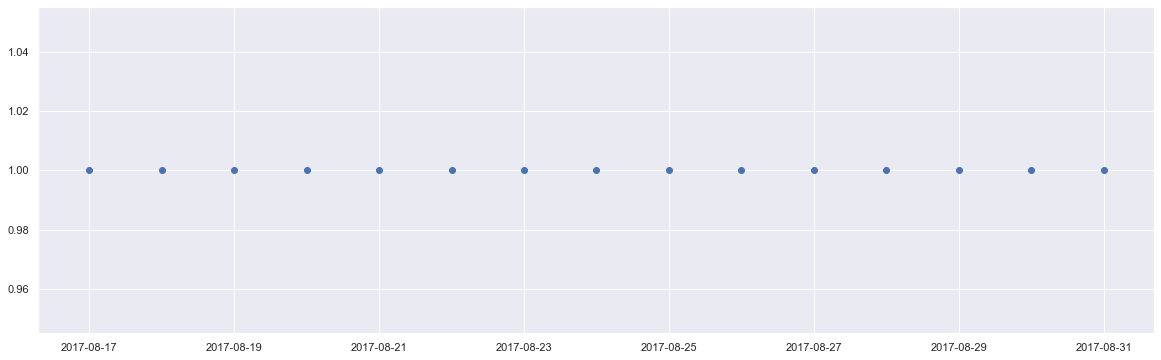

 
HOLIDAYS
Columns:  ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
Unique values: 169
 First observation:  2012-12-05 00:00:00 
 Last observation:  2017-12-26 00:00:00
Gaps between observed data


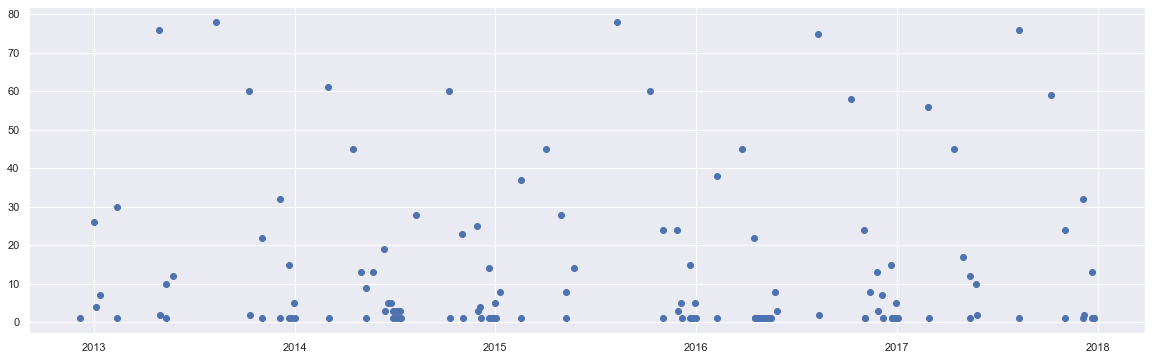

 
OIL
Columns:  ['date', 'price']
Unique values: 1218
 First observation:  2013-01-01 00:00:00 
 Last observation:  2017-08-31 00:00:00
Gaps between observed data


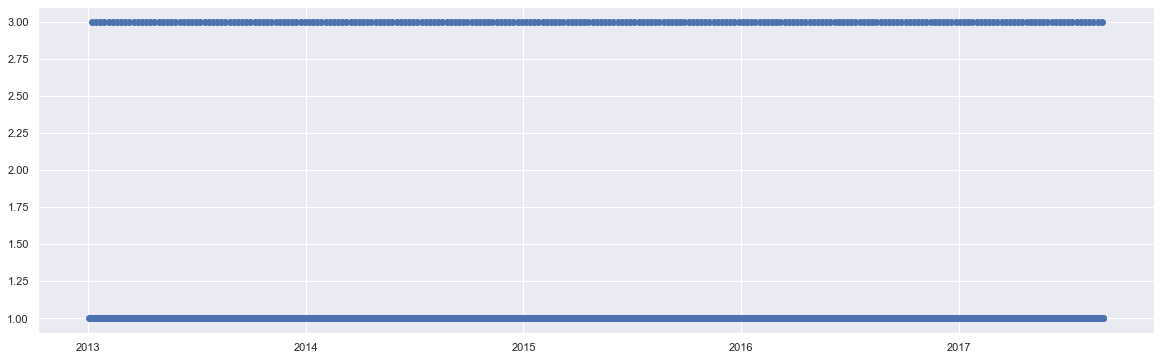

 
TRANSACTIONS
Columns:  ['date', 'store_nbr', 'transactions']
Unique values: 1676
 First observation:  2013-01-02 00:00:00 
 Last observation:  2017-08-15 00:00:00
Gaps between observed data


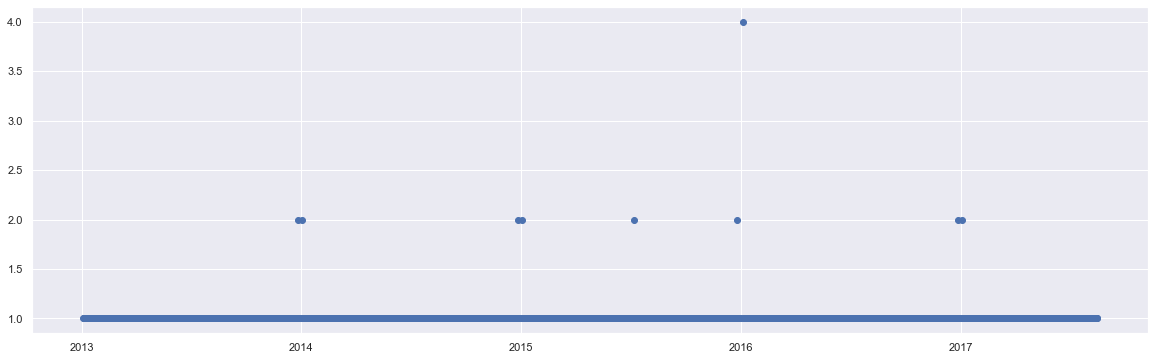

In [37]:
#we check the different dataframes to find the ones that have timeseries data
for name, data in dataframes.items():
    if 'date' in data.columns:
        print(name.upper())
        print('Columns: ', data.columns.to_list())
        print('Unique values:', len(data.date.unique()))
        first_date = min(data.date)
        last_date = max(data.date)
        print(' First observation: ', first_date,'\n','Last observation: ', last_date)
        print('Gaps between observed data')
        check_gaps(data)
        print(' ')

From the plots above we can see:
- The days the store opens are all of them except a day in late December and a date in early January. There is one exception, in mid 2015 there was also a day that store closed
- We can see that in the holiday's data there is a lot of variance between gaps, this makes sense
- The oil data shows that there are 3 gaps which corresponds to weekend data
- Transactions shows that there are even less 2 days gaps than in terms of the days that the store was opened. Maybe some transactions were recorded the day after.

<a id='cleaning'></a>

## Data Cleaning
***

In [38]:
#let's start by dealing with the null values. Only two datasources included null values our train data "on promotion" column, and the oil prices
df[df['onpromotion'].isnull()].head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,578,2013-01-02,1,103665,2.0,NaN
1,579,2013-01-02,1,105574,8.0,NaN
2,580,2013-01-02,1,105575,15.0,NaN
3,581,2013-01-02,1,105577,2.0,NaN
4,582,2013-01-02,1,105737,2.0,NaN


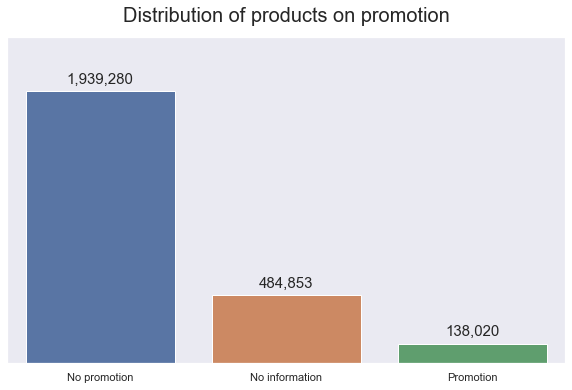

In [39]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
ax = sns.barplot(x=['No promotion', 'No information','Promotion'], y=df['onpromotion'].fillna('No value').value_counts())

#data 
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate('{:,}'.format(round(height)), xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', size=15)
    
#design
plt.grid(False)
plt.title('Distribution of products on promotion', pad=15, size=20)
plt.ylim(0,max(df['onpromotion'].fillna('No value').value_counts())*1.2)
ax.get_yaxis().set_visible(False)


#saving and showing
plt.savefig('img/Items_on_promotion_bar_chart.png', bbox_inches='tight',transparent=True)
plt.show()

In [40]:
# We will assign the value 'No Info' to the missing values
df.onpromotion.fillna('No Info', inplace=True)

In [41]:
df.onpromotion.unique()

array(['No Info', 'False', 'True'], dtype=object)

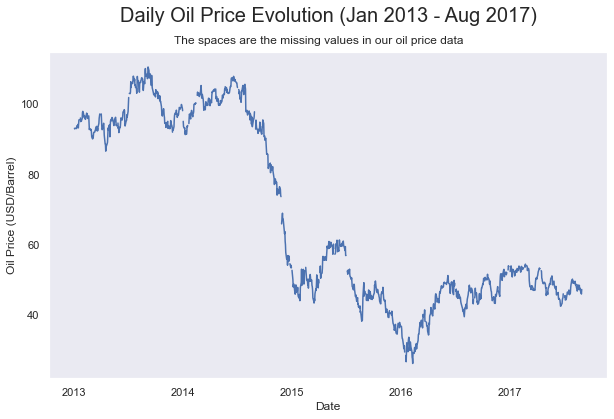

In [42]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
plt.plot(oil.set_index('date'))

#design
plt.grid(False)
plt.title('Daily Oil Price Evolution (Jan 2013 - Aug 2017)', pad=30, size=20)
plt.figtext(.5,.90,'The spaces are the missing values in our oil price data',fontsize=12,ha='center')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD/Barrel)')

#saving and showing
plt.savefig('img/oilprice_evolution_missing_data.png', bbox_inches='tight',transparent=True)
plt.show()

In [43]:
#let's see what is the best way to fill in the missing data
check = oil.copy(deep=True)
check['price_ffill'] = check['price'].fillna(method='ffill')
check['price_linear'] = check['price'].interpolate(method='linear')
check['price_quadratic'] = check['price'].interpolate(method='quadratic')
check['price_nearest'] = check['price'].interpolate(method='nearest')
check[check['price'].isnull()].head()

,date,price,price_ffill,price_linear,price_quadratic,price_nearest
0,2013-01-01,NaN,NaN,NaN,NaN,NaN
14,2013-01-21,NaN,95.61,95.850,96.074277,95.61
34,2013-02-18,NaN,95.95,96.320,96.316158,95.95
63,2013-03-29,NaN,97.24,97.170,97.212118,97.24
104,2013-05-27,NaN,93.84,94.245,94.527430,93.84


In [44]:
#let's go for linear 
oil.price.interpolate(method='linear', inplace=True)

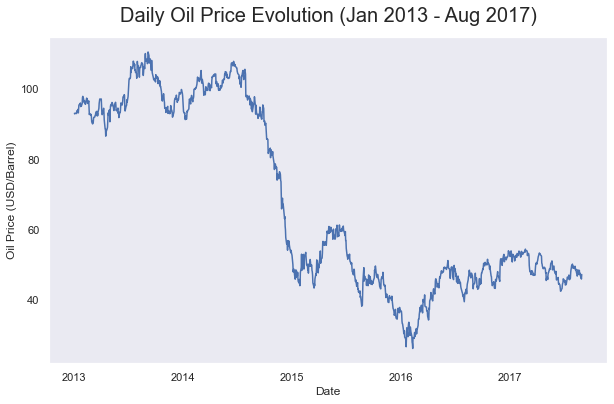

In [45]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
plt.plot(oil.set_index('date'))

#design
plt.grid(False)
plt.title('Daily Oil Price Evolution (Jan 2013 - Aug 2017)', pad=15, size=20)
plt.xlabel('Date')
plt.ylabel('Oil Price (USD/Barrel)')

#saving and showing
plt.savefig('img/oilprice_evolution_interpolate_linear.png', bbox_inches='tight',transparent=True)
plt.show()

In [46]:
#we can also set the oil price for the weekend as the closing price for Friday
oil = oil.set_index('date').asfreq('d').fillna(method='ffill')

In [47]:
oil

,price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.12
...,...
2017-08-27,47.65
2017-08-28,46.40
2017-08-29,46.46


In [48]:
print('Nulls Oil dataset')
nulls(oil.iloc[1:,:]) #we skip the first value
print(' ')
print('Nulls Train dataset')
nulls(df)

Nulls Oil dataset
price 0.0%
 
Nulls Train dataset
id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 0.0%


We can see that there are no more null values

In [49]:
for name, data in dataframes.items():
    print(name.upper())
    print(data.shape)
    print()

TRAIN
(2562153, 6)

TEST
(62416, 5)

ITEMS
(3567, 4)

STORES
(54, 5)

HOLIDAYS
(173, 6)

OIL
(1218, 2)

TRANSACTIONS
(1676, 3)



<a id='merge'></a>


## Merging the datasets
***

In this last section I will merge the different datasets into one to make it easier to analyse in our next step EDA

In [50]:
df = df.merge(items, how='left', on='item_nbr')
df = df.merge(oil, how='left', on='date')
df = df.merge(transactions, how='left', on='date')

**Holidays:** for this dataset we will need to make some edits before we merge it.

**Note from the original dataset:** Pay special attention to the `transferred` column. A holiday that is `transferred` officially falls on that calendar day, but was moved to another date by the government. A `transferred` day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where `type` is `Transfer`. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type `Bridge` are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type `Work Day` which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the `Bridge`.
`Additional` holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [51]:
#our goal is to reduce the dataframe to only three types of days "Holidays", "Event", and "Work Day"
#we start by eliminating the "transferred" days since we are told they are "Normal" days
holidays = holidays[holidays['transferred'] != 'True']

In [52]:
#we convert "Transfer", "Bridge", and "Additional" to "Holidays"
holidays['type'] = holidays['type'].apply(lambda x: 'Holiday' if x in ['Bridge','Additional','Transfer'] else x)

In [53]:
#result
np.unique(holidays['type'])

array(['Event', 'Holiday', 'Work Day'], dtype=object)

In [54]:
df = df.merge(holidays, how='left', on='date')

In [55]:
df.columns

Index(['id', 'date', 'store_nbr_x', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'price', 'store_nbr_y', 'transactions',
       'type', 'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [56]:
df = df.drop(['store_nbr_x','store_nbr_y','locale','locale_name','description','transferred'], axis=1)

In [57]:
nulls(df)

id 0.0%
date 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 0.0%
family 0.0%
class 0.0%
perishable 0.0%
price 0.0%
transactions 0.1242711915084467%
type 91.30615562864405%


In [58]:
df['transactions'] = df['transactions'].fillna(0)

In [59]:
df['dow'] = df['date'].dt.weekday

In [60]:
# We create the list of the conditions we want to apply
conditions = [
    (df['type'].isnull()) & (df['dow'].isin([5,6])), # 5 and 6 are Saturday and Sunday
    (df['type'].isnull()), # Every other day without a Holiday, Event, or Weekend, will be a Work Day
    (df['type'].notnull()) # This will keep the "type" that we already have
    ]

# create a list of the values we want to assign for each condition
values = ['Weekend', 'Work Day', df['type']]

# we substitute our column with np.select to assign values to it using our lists as arguments
df['type'] = np.select(conditions, values)

In [61]:
df.type.value_counts()

Work Day    1756259
Weekend      596121
Holiday      122453
Event         93743
Name: type, dtype: int64

In [62]:
df

,id,date,item_nbr,unit_sales,onpromotion,family,class,perishable,price,transactions,type,dow
0,578,2013-01-02,103665,2.0,No Info,BREAD/BAKERY,2712,1,93.14,2111.0,Work Day,2
1,579,2013-01-02,105574,8.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
2,580,2013-01-02,105575,15.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
3,581,2013-01-02,105577,2.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
4,582,2013-01-02,105737,2.0,No Info,GROCERY I,1044,0,93.14,2111.0,Work Day,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2568571,125396207,2017-08-15,2114812,1.0,True,CLEANING,3020,0,47.57,1693.0,Work Day,1
2568572,125396208,2017-08-15,2116416,1.0,False,GROCERY I,1060,0,47.57,1693.0,Work Day,1
2568573,125396209,2017-08-15,2122188,1.0,False,GROCERY I,1084,0,47.57,1693.0,Work Day,1
2568574,125396210,2017-08-15,2122676,2.0,False,BEVERAGES,1124,0,47.57,1693.0,Work Day,1


<a id='saving'></a>


## Saving the datasets
***

In [64]:
# finally, we save the new dataframe as a csv file.
df.to_csv('../../data/train_clean.csv')
test.to_csv('../../data/test.csv')
items.to_csv('../../data/items.csv')
holidays.to_csv('../../data/holidays.csv')
oil.to_csv('../../data/oil.csv')
transactions.to_csv('../../data/transactions.csv')